In [1]:
import pandas as pd
import pandas as pd
from process_data import DataProcessor
from prophet import Prophet
from sklearn.preprocessing import RobustScaler

# Loading the data
X_train = pd.read_csv('data/single_turbine_data/X_train.csv')
X_test = pd.read_csv('data/single_turbine_data/X_test.csv')
y_train = pd.read_csv('data/single_turbine_data/y_train.csv')
y_test = pd.read_csv('data/single_turbine_data/y_test.csv')

y_train['# Date and time'] = pd.to_datetime(y_train['# Date and time'])
y_test['# Date and time'] = pd.to_datetime(y_test['# Date and time'])

y_train.set_index('# Date and time', inplace=True)
y_test.set_index('# Date and time', inplace=True)

processor = DataProcessor(X_train)
processor.process_all()
X_train = processor.data

processor = DataProcessor(X_test)
processor.process_all()
X_test = processor.data

original_cols = ['1_Wind direction (°)',
       '1_Nacelle position (°)', '1_Power (kW)',
       '1_Front bearing temperature (°C)', '1_Rear bearing temperature (°C)',
       '1_Stator temperature 1 (°C)', '1_Nacelle ambient temperature (°C)',
       '1_Nacelle temperature (°C)', '1_Transformer temperature (°C)',
       '1_Generator bearing rear temperature (°C)',
       '1_Generator bearing front temperature (°C)', '1_Temp. top box (°C)',
       '1_Hub temperature (°C)', '1_Ambient temperature (converter) (°C)',
       '1_Rotor bearing temp (°C)', '1_Transformer cell temperature (°C)', '1_Generator RPM (RPM)']
leadsnlags = [
       '1_Wind direction (°)_lead6', 
       '1_Nacelle position (°)_lead3',
       '1_Power (kW)_lag6', 
       '1_Stator temperature 1 (°C)_lag1',
       '1_Nacelle ambient temperature (°C)_lead6',
       '1_Transformer temperature (°C)_lead6',
       '1_Generator bearing rear temperature (°C)_lag1',
       '1_Temp. top box (°C)_lag1', 
       '1_Hub temperature (°C)_lead6',
       '1_Ambient temperature (converter) (°C)_lead6',
       '1_Transformer cell temperature (°C)_lead6',
       '1_Generator RPM (RPM)_lead6']
extras = ['curtailed', 'offline']

cols = original_cols
X_train = X_train[cols]
X_test = X_test[cols]

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

all_data = pd.concat([train_data, test_data], axis=0)

/Users/johnny/Library/CloudStorage/OneDrive-Personal/py/RES_hackathons/Temp Sensor/process_data.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_column_name] = df[feature].shift(-steps)
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/john

In [2]:
y_train[cols] = X_train[cols]

# promote index to column
y_train.reset_index(inplace=True)
# rename date column to ds
y_train.rename(columns={'# Date and time': 'ds', '1_Gear oil temperature (°C)': 'y'}, inplace=True)


In [3]:

model = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=1.0, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, interval_width=0.95, mcmc_samples=0)
for col in cols:
    model.add_regressor(col)

model.fit(y_train)
import pandas as pd

periods = len(y_test)
future = model.make_future_dataframe(periods=periods, freq='10min')

for col in cols:
    concatenated_series = pd.concat([X_train[col], X_test[col].iloc[:periods]])

    future[col] = concatenated_series.reset_index(drop=True)

# Perform prediction
fcst = model.predict(future)

21:51:25 - cmdstanpy - INFO - Chain [1] start processing
21:51:40 - cmdstanpy - INFO - Chain [1] done processing


In [4]:

# # Python
# import itertools
# import numpy as np
# import pandas as pd
# from prophet.diagnostics import performance_metrics
# from prophet.diagnostics import cross_validation

# param_grid = {  
#     'changepoint_prior_scale': [0.0001, 0.005, 0.001],
#     'seasonality_prior_scale': [1],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params)
#     for col in cols:
#         m.add_regressor(col)
#     m.fit(y_train)
#     df_cv = cross_validation(m, initial = '730 days', horizon='365 days', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

In [5]:
# rsme of last 300 points in fct against first 300 points in y_test

from sklearn.metrics import mean_squared_error

y_tested = y_test[:periods]
fcsted = fcst[-periods:]

mean_squared_error(y_tested['1_Gear oil temperature (°C)'], fcsted['yhat'], squared=False)

/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/johnny/anaconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstan

0.9920542837608103

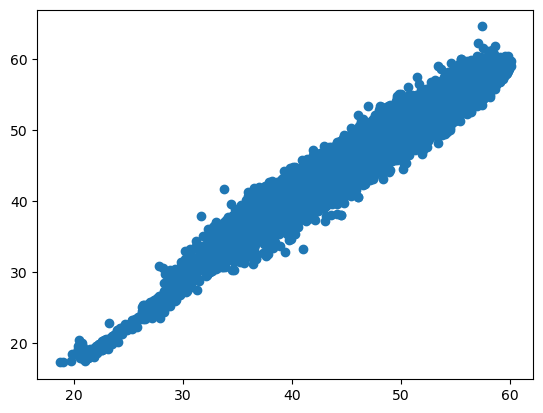

In [5]:
import matplotlib.pyplot as plt
plt.scatter(y_tested['1_Gear oil temperature (°C)'], fcsted['yhat'])

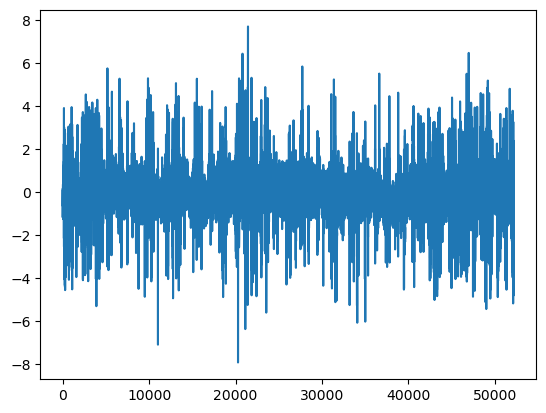

In [6]:
# plot the difference over time
plt.plot(range(len(y_tested['1_Gear oil temperature (°C)'])), y_tested['1_Gear oil temperature (°C)'].to_numpy() - fcsted['yhat'].to_numpy())

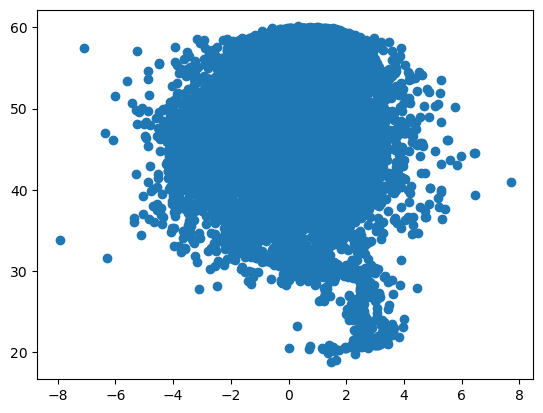

In [7]:
# plot the difference against the truth
plt.scatter(y_tested['1_Gear oil temperature (°C)'].to_numpy() - fcsted['yhat'].to_numpy(), y_tested['1_Gear oil temperature (°C)'])

((array([-4.20116808, -3.99587499, -3.88396845, ...,  3.88396845,
          3.99587499,  4.20116808]),
  array([-7.92067911, -7.09203564, -6.36716882, ...,  6.44759421,
          6.48057299,  7.71007966])),
 (0.9187084917571715, 0.04332724104605513, 0.9739139840973092))

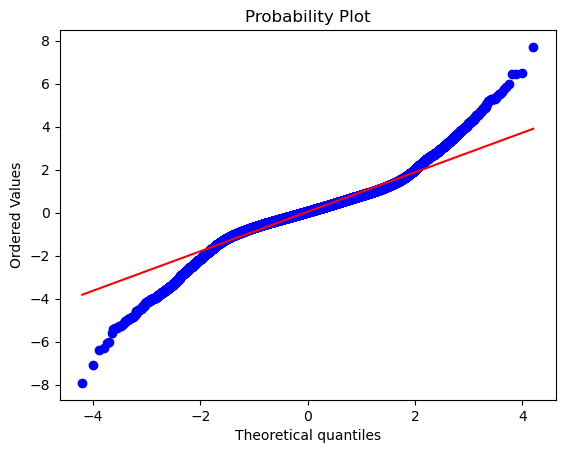

In [8]:
# qq plot
import scipy.stats as stats

stats.probplot(y_tested['1_Gear oil temperature (°C)'].to_numpy() - fcsted['yhat'].to_numpy(), dist="norm", plot=plt)